# Which Songs are most suitable for a Dancing Party?

## 📖 Background
It's that vibrant time of year again - Summer has arrived (for those of us in the Northern Hemisphere at least)! There's an energy in the air that inspires us to get up and move. In sync with this exuberance, your company has decided to host a dance party to celebrate. And you, with your unique blend of creativity and analytical expertise, have been entrusted with the crucial task of curating a dance-themed playlist that will set the perfect mood for this electrifying night. The question then arises - How can you identify the songs that would make the attendees dance their hearts out? This is where your coding skills come into play.

## 💾 The Data
You have assembled information on more than `125` genres of Spotify music tracks in a file called `spotify.csv`, with each genre containing approximately `1000` tracks. All tracks, from all time, have been taken into account without any time period limitations. However, the data collection was concluded in `October 2022`.
Each row represents a track that has some audio features associated with it.

| Column     | Description              |
|------------|--------------------------|
| `track_id` | The Spotify ID number of the track. |
| `artists` | Names of the artists who performed the track, separated by a `;` if there's more than one.|
| `album_name` | The name of the album that includes the track.|
| `track_name` | The name of the track.|
| `popularity` | Numerical value ranges from `0` to `100`, with `100` being the highest popularity. This is calculated based on the number of times the track has been played recently, with more recent plays contributing more to the score. Duplicate tracks are scored independently.|
| `duration_ms` | The length of the track, measured in milliseconds.|
| `explicit` | Indicates whether the track contains explicit lyrics. `true` means it does, `false` means it does not or it's unknown.|
| `danceability` | A score ranges between `0.0` and `1.0` that represents the track's suitability for dancing. This is calculated by algorithm and is determined by factors like tempo, rhythm stability, beat strength, and regularity.|
| `energy` | A score ranges between `0.0` and `1.0` indicating the track's intensity and activity level. Energetic tracks tend to be fast, loud, and noisy.|
| `key` | The key the track is in. Integers map to pitches using standard Pitch class notation. E.g.`0 = C`, `1 = C♯/D♭`, `2 = D`, and so on. If no key was detected, the value is `-1`.| 
| `loudness` | The overall loudness, measured in decibels (dB).|
| `mode` |  The modality of a track, represented as `1` for major and `0` for minor.| 
| `speechiness` | Measures the amount of spoken words in a track. A value close to `1.0` denotes speech-based content, while `0.33` to `0.66` indicates a mix of speech and music like rap. Values below `0.33` are usually music and non-speech tracks.| 
| `acousticness` | A confidence measure ranges from `0.0` to `1.0`, with `1.0` representing the highest confidence that the track is acoustic.|
| `instrumentalness` | Instrumentalness estimates the likelihood of a track being instrumental. Non-lyrical sounds such as "ooh" and "aah" are considered instrumental, whereas rap or spoken word tracks are classified as "vocal". A value closer to `1.0` indicates a higher probability that the track lacks vocal content.|
| `liveness` | A measure of the probability that the track was performed live. Scores above `0.8` indicate a high likelihood of the track being live.|
| `valence` | A score from `0.0` to `1.0` representing the track's positiveness. High scores suggest a more positive or happier track.|
| `tempo` | The track's estimated tempo, measured in beats per minute (BPM).|
| `time_signature` | An estimate of the track's time signature (meter), which is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from `3` to `7` indicating time signatures of `3/4`, to `7/4`.|
| `track_genre` |  The genre of the track.|

[Source](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset) (data has been modified)

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import chain
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv('./data/spotify.csv')

# 1. Interviewing Data
1. View sample data rows to quickly inspect and understand the contents of the spotify dataset
2. Check the number of non-null values, data types, and memory usage.
3. Check the unique values and if there are any discrepancies.
4. View summary statistics of the dataframe to get a sense of the distribution of the variables.

## 1.1 View sample data rows to quickly inspect and understand the contents of the spotify dataset

In [46]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666.0,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610.0,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826.0,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933.0,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853.0,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 1.2 View sample data rows to quickly inspect and understand the contents of the spotify dataset

In [47]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113027 entries, 0 to 113026
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113027 non-null  object 
 1   artists           113026 non-null  object 
 2   album_name        113026 non-null  object 
 3   track_name        113026 non-null  object 
 4   popularity        113027 non-null  int64  
 5   duration_ms       113027 non-null  float64
 6   explicit          113027 non-null  bool   
 7   danceability      113027 non-null  float64
 8   energy            113027 non-null  float64
 9   key               113027 non-null  int64  
 10  loudness          113027 non-null  float64
 11  mode              113027 non-null  int64  
 12  speechiness       113027 non-null  float64
 13  acousticness      113027 non-null  float64
 14  instrumentalness  113027 non-null  float64
 15  liveness          113027 non-null  float64
 16  valence           11

### Observations:
- There are about 113k observations and 19 features in total.
- artists, album_name and track_name has one null value.
    - Check if all three null values belong to the same observation.
    - Check if the null values can be filled with the help of track_id.

## 1.3 Check the unique values and if there are any discrepancies.

In [48]:
print(df.nunique())

track_id            88895
artists             31267
album_name          46325
track_name          72935
popularity            101
duration_ms         50278
explicit                2
danceability         1169
energy               2064
key                    12
loudness            19292
mode                    2
speechiness          1483
acousticness         5053
instrumentalness     5345
liveness             1721
valence              1779
tempo               45242
time_signature          4
track_genre           114
dtype: int64


### Observation:
- track_id does not uniquely identify each observation as it is not equal to the total number of rows in the dataset. This needs further investigation as there seems to be exact duplicate rows (or) almost-exact duplicate rows.

## 1.4 View summary statistics of the dataframe to get a sense of the distribution of the variables.

In [49]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113027.000000,1.130270e+05,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000,113027.000000
mean,33.274386,2.281997e+05,0.568038,0.642947,5.312262,-8.219194,0.637299,0.084294,0.312539,0.154746,0.213274,0.475278,122.267773,3.929035
std,22.322053,1.070011e+05,0.172955,0.250418,3.560905,4.983277,0.480782,0.104315,0.331113,0.308316,0.190024,0.259022,29.961328,0.339922
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.743575e+05,0.457000,0.474000,2.000000,-9.971000,0.000000,0.035900,0.016700,0.000000,0.097900,0.261000,99.559500,4.000000
50%,35.000000,2.130530e+05,0.581000,0.686000,5.000000,-6.981000,1.000000,0.048900,0.166000,0.000041,0.132000,0.465000,122.043000,4.000000
75%,50.000000,2.615620e+05,0.695000,0.854000,8.000000,-4.993500,1.000000,0.084500,0.592000,0.046900,0.273000,0.684000,140.093000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


### Observations:
- Variables such as popularity, duration_ms, danceability, energy, key, valence, tempo, time_signature have closer mean and median values. So, these variables seem to be **roughly symmetric and relatively free from skewness**. Lets see what the eda has to tell.
- Loudness has negative values.
    - Has to be changed to absolute values.

## Check if null value in artists, album_name and track_name can be filled

In [50]:
df[df['artists'].isnull()]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65326,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0.0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


The above null value can't be filled as there are no two rows with the same track_id.

## Investigating track_id total unique values discrepancy

In [51]:
filter_df = df['track_id'].value_counts().reset_index()
track_duplicates_list = list(filter_df[filter_df['track_id']>=2]['index'])
track_duplicates = df[df['track_id'].isin(track_duplicates_list)].sort_values('track_id')
track_duplicates.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
14908,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,0,176320.0,False,0.613,0.471,1,-6.644,0,0.1070,0.31600,0.000001,0.1170,0.406,143.064,4,chill
102298,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,0,176320.0,False,0.613,0.471,1,-6.644,0,0.1070,0.31600,0.000001,0.1170,0.406,143.064,4,soul
2092,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973.0,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,alt-rock
3242,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973.0,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,alternative
91020,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973.0,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,rock


### Observation:
 - In the resulting DataFrame, it's evident that the **explode function** was applied to the Spotify dataset using the track_genre column. As a result, each row may not represent a single track, and in cases where a track has multiple genres, there are multiple rows for that track. Consequently, this situation leads to duplicate values in other columns, which require appropriate handling.

# 2. Cleaning Data
1. Removing exact duplicates
2. Removing artists, albumname, trackname column (assuming artist's doesnt explain the variance in danceability)
3. Converting duration in microseconds(ms) to seconds(s)

## 2.1 Removing exact duplicates

In [52]:
df = df.drop_duplicates()

444 exact duplicates were removed with the above command

## 2.2 Removing artists, albumname, trackname column (assuming artist's doesnt explain the variance in danceability)

In [53]:
df = df.drop(columns=['artists', 'album_name', 'track_name'])

## 2.3 Converting duration in microseconds(ms) to seconds(s)

In [54]:
# converting ms to s
df['duration_ms'] = df['duration_ms']/1000
df.rename(columns = {'duration_ms':'duration_s'}, inplace = True)

## 2.4 explicit column from bool to 1's and 0's

In [55]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)

## Imploding track_genre column

In [56]:
def join_genres(genres):
    return ','.join(genres)

agg_dict = {
    'track_genre': join_genres,
    'popularity': 'first',
    'duration_s': 'first',
    'explicit': 'first',
    'danceability': 'first',
    'energy': 'first',
    'key': 'first',
    'loudness': 'first',
    'mode': 'first',
    'speechiness': 'first',
    'acousticness': 'first',
    'instrumentalness': 'first',
    'liveness': 'first',
    'valence': 'first',
    'tempo': 'first',
    'time_signature': 'first'
}

imploded_df = df.groupby('track_id', as_index=False).agg(agg_dict)

## Exploding track_genre column

In [57]:
# explode result_df
exploded_df = imploded_df.copy()
exploded_df['track_genre'] = exploded_df['track_genre'].str.split(',')
exploded_df = exploded_df.explode('track_genre')

### Purpose of Implode and Explode Operations:
- The DataFrame was initially imploded using the track_genre column, resulting in unique identification of rows by track_id, and comma-separated values in the track_genre column. This step addresses duplicate values in other columns, facilitating subsequent analytics and model development.
- Subsequently, the DataFrame was exploded to enable analysis based on the track_genre column. This step aims to investigate the potential significance of track_genre in explaining variations in the danceability column.

# 3. Exploratory Data Analysis
    1. Exploring Continuous Attributes
    2. Exploring explicit, key, mode, time_signature attributes
    3. Exploring track_genre feature
    4. Genre Co-occurence
    5. Correlation Heatmap
    6. Scatter Plots

## 3.1 Exploring Continuous Attributes

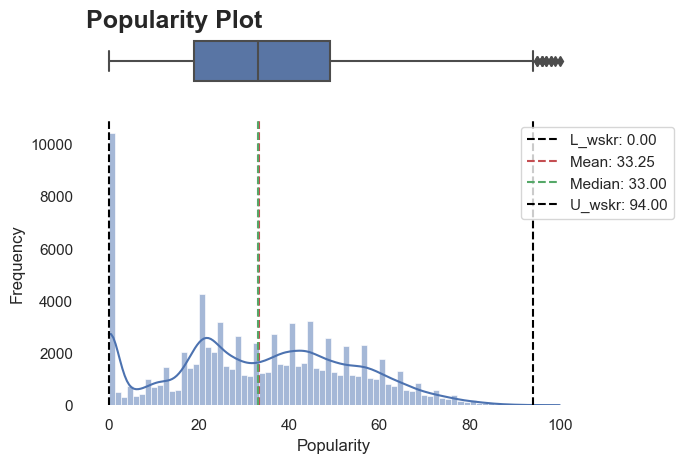

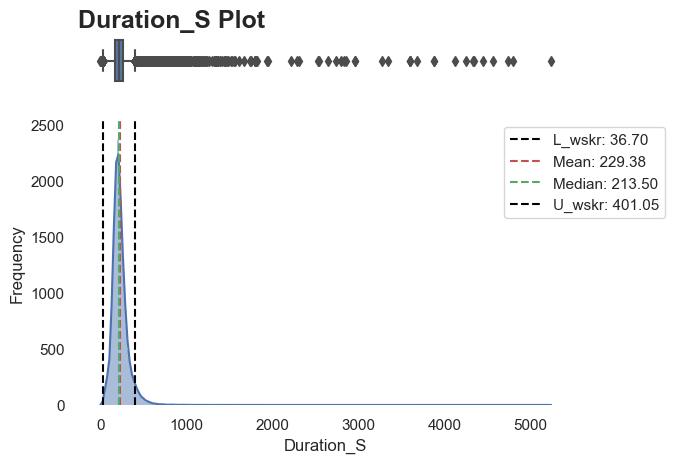

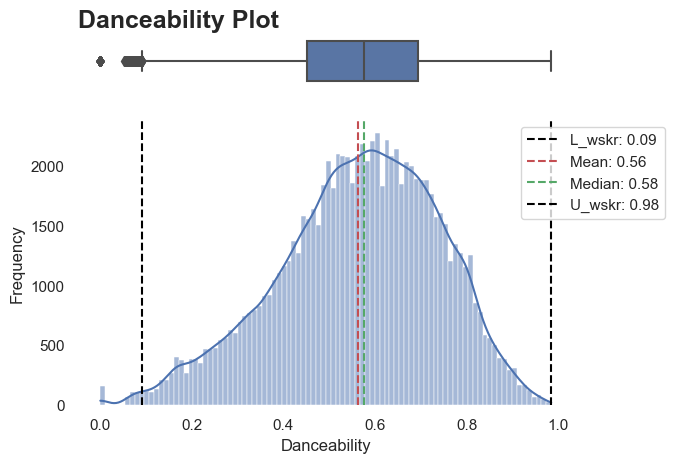

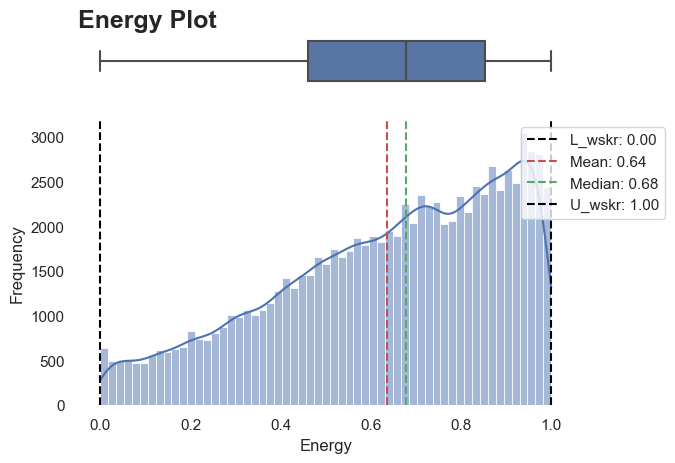

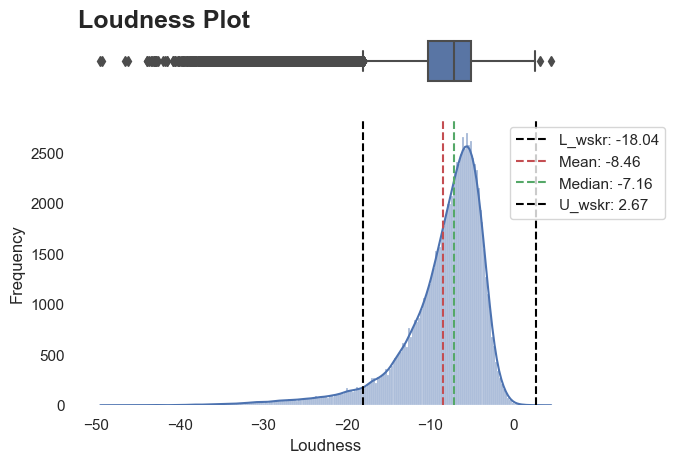

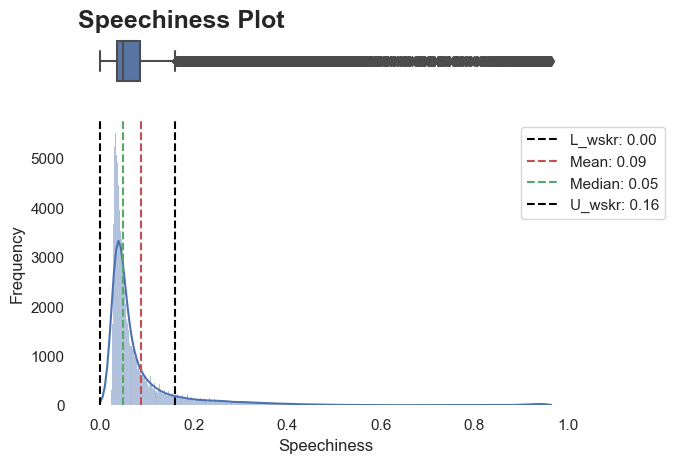

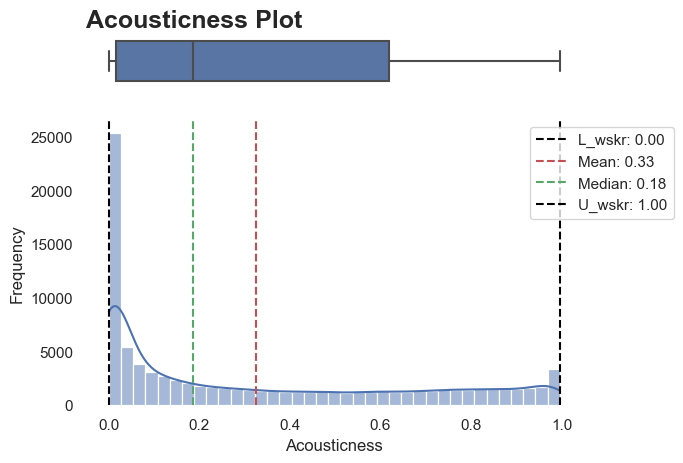

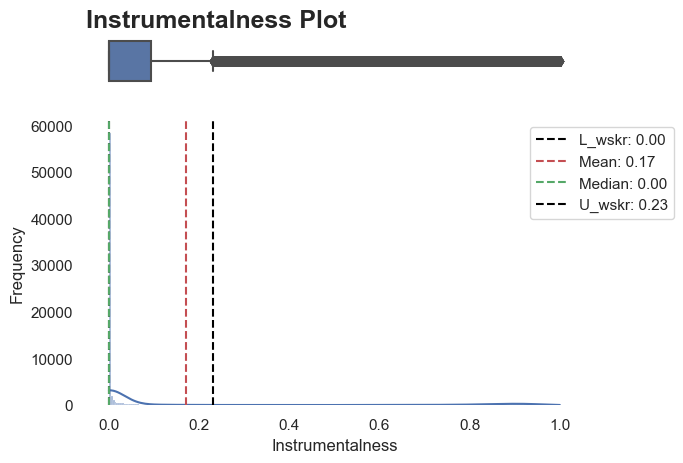

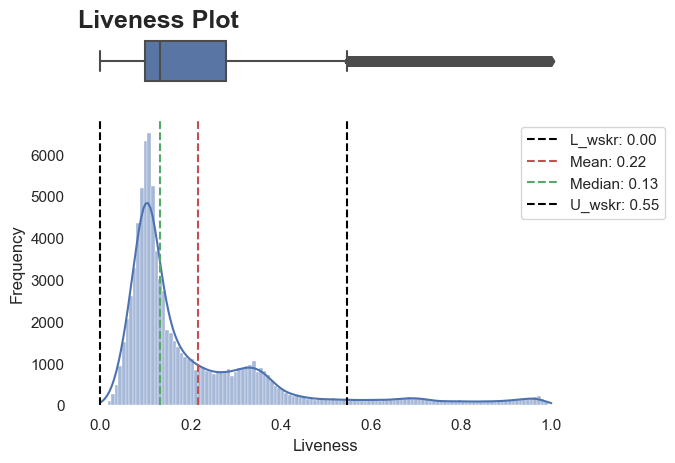

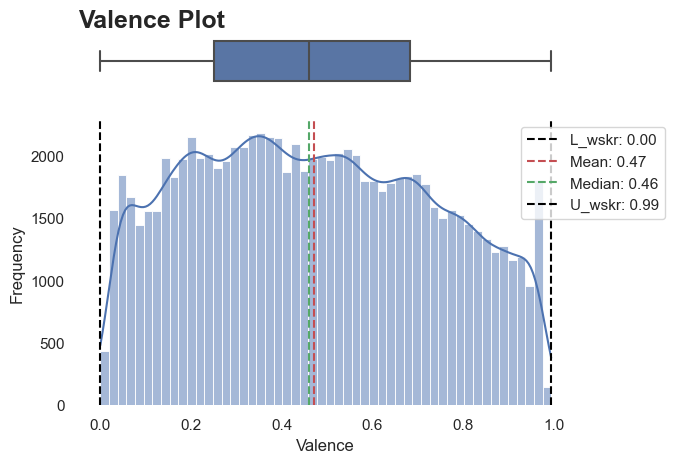

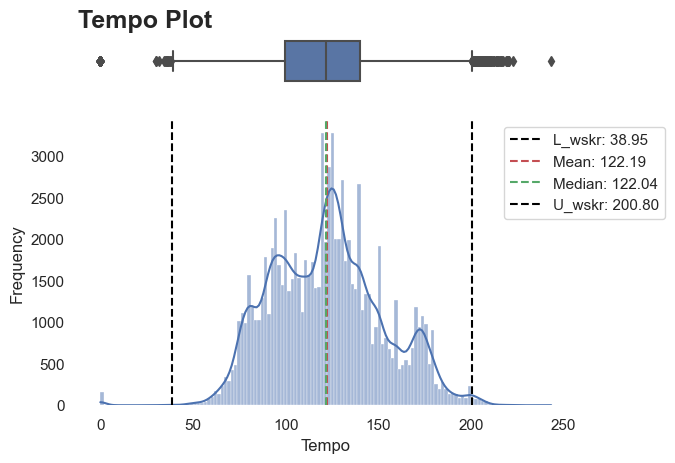

In [58]:
columns_to_plot = ['popularity', 'duration_s', 'danceability', 'energy',
                    'loudness', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo']

# Histogram and Boxplot of continuous audio features
for col in columns_to_plot:
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(x=imploded_df[col], ax=ax_box, orient='h')
    sns.histplot(imploded_df[col], ax=ax_hist, kde=True)
    
    ax_box.set_xlabel('')
    ax_hist.set_xlabel(col.title())
    
    mean_val = imploded_df[col].mean()
    median_val = imploded_df[col].median()
    q25 = imploded_df[col].quantile(0.25)
    q75 = imploded_df[col].quantile(0.75)
    iqr = q75 - q25
    lower_limit = max(imploded_df[col].min(), q25 - 1.5 * iqr)
    upper_limit = min(imploded_df[col].max(), q75 + 1.5 * iqr)
    
    ax_hist.axvline(lower_limit, color='black', linestyle='--', label=f'L_wskr: {lower_limit:.2f}')
    ax_hist.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
    ax_hist.axvline(median_val, color='g', linestyle='--', label=f'Median: {median_val:.2f}')
    ax_hist.axvline(upper_limit, color='black', linestyle='--', label=f'U_wskr: {upper_limit:.2f}')
    ax_hist.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax_box.set_title(f'{col.title()} Plot', loc='left', fontsize=18, fontweight='bold')
    ax_hist.set_ylabel('Frequency')

    ax_box.spines['top'].set_visible(False)
    ax_box.spines['right'].set_visible(False)
    ax_box.spines['bottom'].set_visible(False)
    ax_box.spines['left'].set_visible(False)
    ax_box.grid(False)

    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['bottom'].set_visible(False)
    ax_hist.spines['left'].set_visible(False)
    ax_hist.grid(False)
    
    plt.show()

### Observations:
- **Popularity**
    1. Approximately 9.3k tracks with a popularity score of 0 haven't been played anytime remotely recently. Among these, the top genres are jazz (7%), Iranian (6%), soul (6%), and country (6%). This indicates that these genres have faded in popularity over time, with listeners favoring other genres.
    2. There are 15 tracks with a popularity score exceeding 90. Four of these are standalone pop songs currently dominating the popular charts, and two are reggae tracks.
    3. The mean and median popularity scores are both around 33, suggesting that roughly 50k tracks belong to the lower third of popularity. The dataset is not significantly affected by outlier tracks with popularity scores above 94.
    4. The proportion of tracks gradually decreases as popularity exceeds ~55. Fewer songs have higher popularity scores, suggesting a cyclical pattern where popular songs tend to stay in the limelight, leaving only a few tracks with scores above 45, while most tracks lag behind in terms of popularity.
- **Duration_s**
    1. There are around 4k outliers in the duration_s (duration in seconds) category, although their influence on the mean is not substantial, as it remains relatively close to the median. The curve is characterized by high leptokurtosis and removing these outliers would result in a more normally distributed plot.
    2. techno and chicago-house songs tend to have longer durations and are considered outliers. Additionally, there are a few breakbeat tracks with durations exceeding 2000 seconds, making them prominent among the extreme outliers.
    3. The mean duration of a song is approximately 40 minutes.
- **Danceability**
    1. The distribution of this variable follows a normal pattern, with a majority of songs having moderate danceability values. High and low danceability values are less common, with outliers predominantly leaning towards the lower end of the scale.
    2. Interestingly, 50% of these outliers belong to the 'sleep' genre, reflecting the idea that some listeners prefer soothing music for relaxation and sleep.
- **Energy** (Energetic tracks are typically characterized by their speed, loudness, and intensity)
    1. The median energy score is 0.68, indicating that 50% of the songs have higher levels of energy compared to the bottom two-thirds of the dataset.
    2. In the top third of songs, genres like hardstyle, death-metal, and metalcore dominate, while the bottom third is marked by genres such as new age, classical, ambient, and piano.
- **Speechiness** The presence of outliers in speechiness is primarily attributed to 'comedy' tracks, which exhibit unusually high speechiness values. Initially, it seemed that this genre might not contribute to danceability. However, upon closer examination by creating a subset of the dataframe for the comedy genre, it was discovered that these tracks have a mean danceability of 0.57 and a mean energy of 0.7. This suggests that comedy tracks may indeed have an impact on danceability, despite their distinctive speech-focused nature.
- **Instrumentalness** Genres like study, techno, and sleep have a notable presence among the outliers with high instrumentalness values. Combining this observation with our earlier finding that techno songs tend to have longer durations, it becomes apparent that techno tracks are less likely to inspire lively and energetic dancing.
- **Valence** There are no outliers in valence. The mean and median values are in close proximity, and the data appears to exhibit a roughly symmetrical distribution with minimal skew. The curve displays characteristics of a normal distribution and is notably platykurtic.
- **Tempo** Tempo displays an almost normal distribution, with a prominent peak occurring at approximately 125 beats per minute. There are a few outliers, accounting for roughly 1% of the data, distributed on both sides of the graph.
    

## 3.2 Exploring explicit, key, mode, time_signature attributes

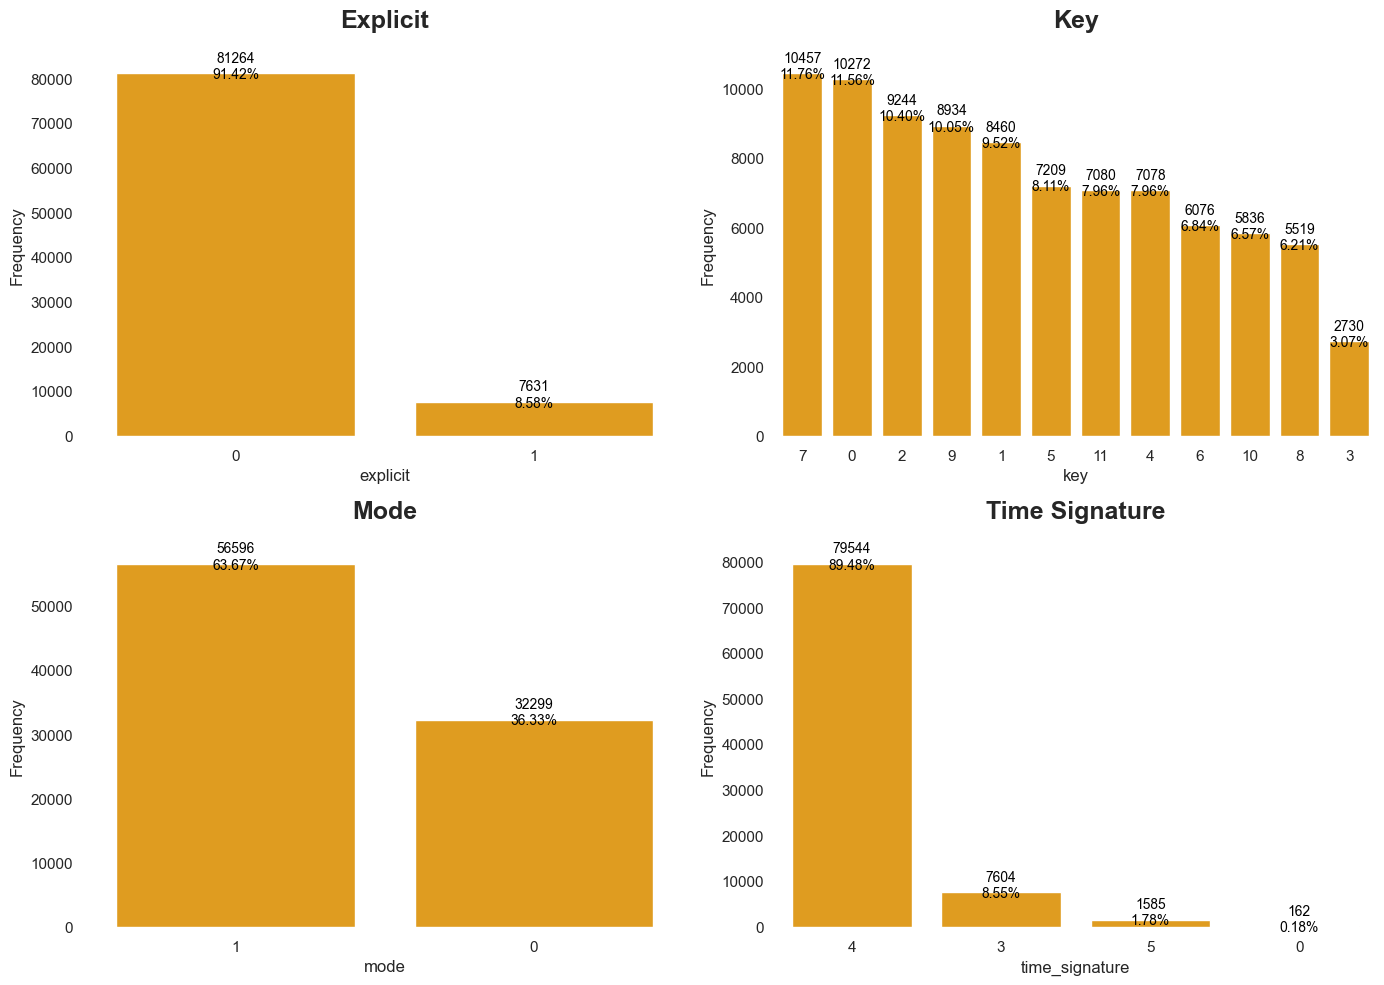

In [59]:
def create_countplot_with_values_and_percentages(data, x_col, ax, title, order=None, color=None):
    sns.countplot(data=data, x=x_col, ax=ax, order=order, color=color)
    ax.set_title(title, fontsize=18, fontweight='bold', y=1.05)

    total_height = len(data)
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}\n{height/total_height:.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
        ax.set_ylabel('Frequency', fontsize=12)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(False)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
bar_color = 'orange'
create_countplot_with_values_and_percentages(imploded_df, 'explicit', axes[0, 0], 'Explicit', order=imploded_df['explicit'].value_counts().index, color=bar_color)
create_countplot_with_values_and_percentages(imploded_df, 'key', axes[0, 1], 'Key', order=imploded_df['key'].value_counts().index, color=bar_color)
create_countplot_with_values_and_percentages(imploded_df, 'mode', axes[1, 0], 'Mode', order=imploded_df['mode'].value_counts().index, color=bar_color)
create_countplot_with_values_and_percentages(imploded_df, 'time_signature', axes[1, 1], 'Time Signature', order=imploded_df['time_signature'].value_counts().index, color=bar_color)

plt.tight_layout()
plt.show()

### Observations:
- Explicit
    1. Approximately 8.5% of the songs feature explicit lyrics, with comedy, emo, and sad genres prominently leading this category.
    2. Explicit tracks exhibit slightly higher danceability, with a mean of 0.63 compared to the overall mean of 0.56
- Mode
    1. Genres such as honky-tonk, country, world-music, children, and bluegrass predominantly consist of songs in the 'major' mode, accounting for more than 85% of their total compositions. This suggests that within these genres, tracks are more inclined to be either major or minor, rather than being evenly distributed between the two modes.
    2. Analysis of the data reveals that there are no substantial differences in the mean and median values of danceability and energy between tracks in the major and minor modes.
- Time Signature
    1. Approximately 90% of the dataset is represented by songs with a time signature of 4.
    2. The remaining 10% of the dataset consists of songs with time signatures 3, 5, or 0. These songs exhibit lower average values for danceability (0.43) and energy (0.45) when compared to songs with a time signature of 4, which have higher mean danceability (0.58) and energy (0.66) values.

## 3.3 Exploring track_genre feature
    1. Ordering Mean Danceability by Genre
    2. Genre Co-occurence

### 3.3.1 Ordering Mean Danceability by Genre

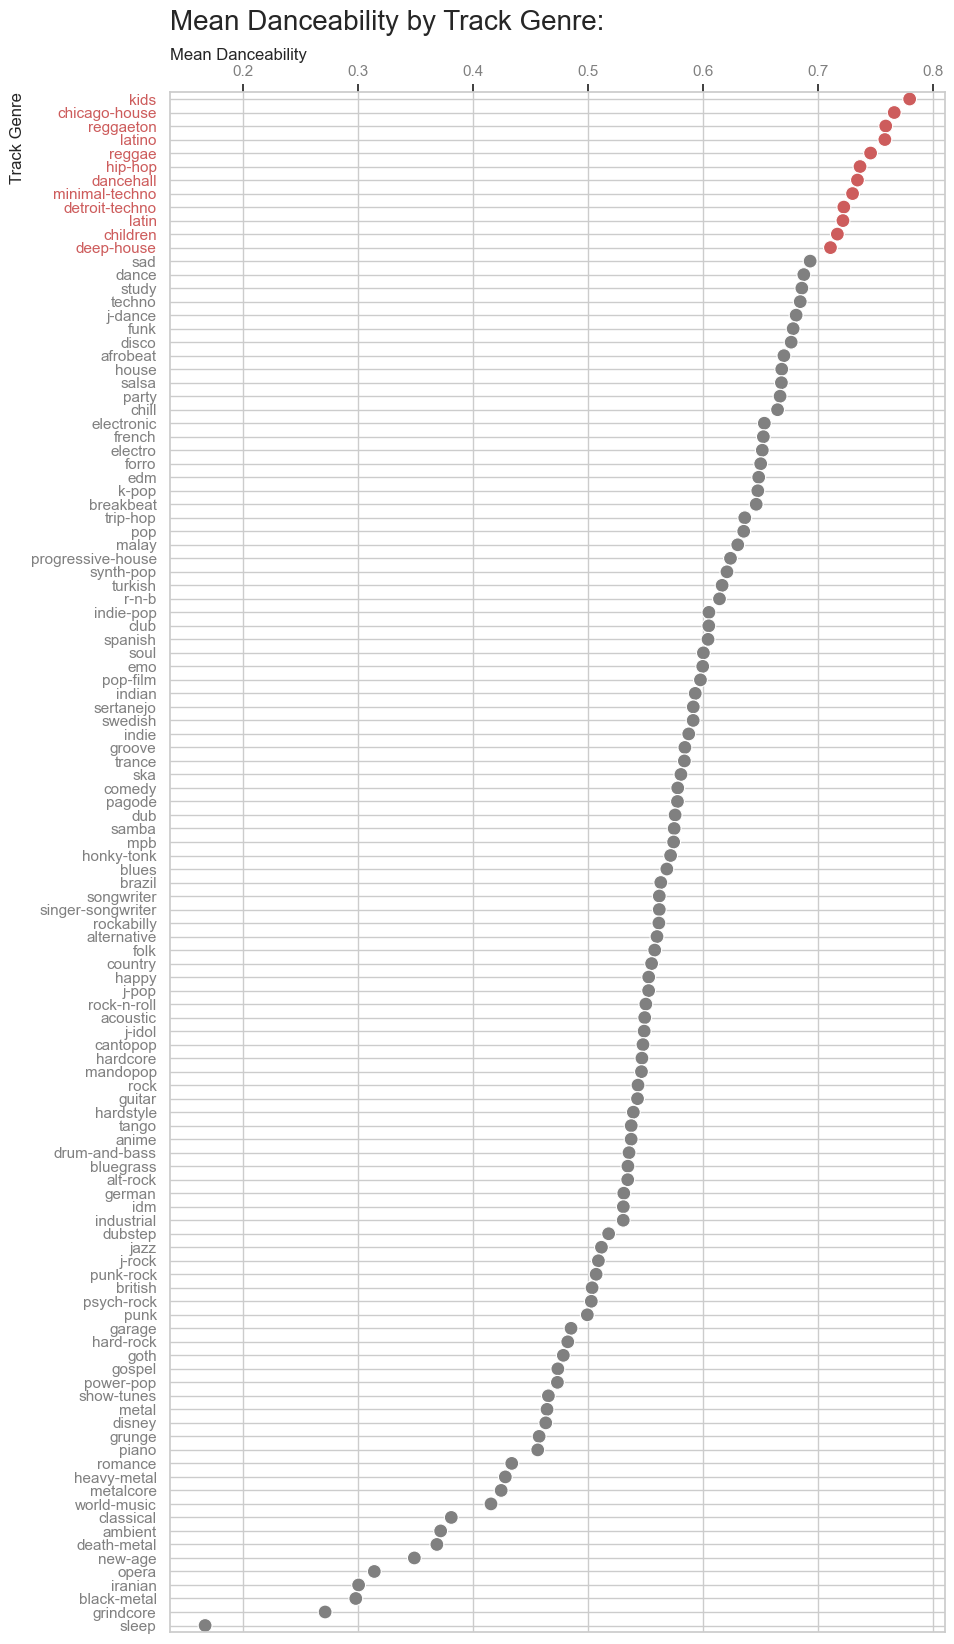

In [60]:
plt.figure(figsize=(10, 20))
sns.set(style="whitegrid")

mean_danceability = exploded_df.groupby('track_genre')['danceability'].mean().reset_index()
mean_danceability = mean_danceability.sort_values(by='danceability', ascending=False)

custom_palette = {'indianred': 'indianred', 'gray': 'gray'}
mean_danceability['color'] = np.where(mean_danceability['danceability'] > 0.7, 'indianred', 'gray')
sns.scatterplot(x='danceability', y='track_genre', data=mean_danceability, s=100, hue='color', palette=custom_palette)

ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xlabel('Mean Danceability', loc='left')
plt.ylabel('Track Genre', loc='top')
plt.title('Mean Danceability by Track Genre:', fontsize=20, loc='left', y=1.035)
plt.legend().remove()

for label in ax.get_xticklabels():
    label.set_color('gray')

for label in ax.get_yticklabels():
    genre = label.get_text()
    row = mean_danceability[mean_danceability['track_genre'] == genre].iloc[0]
    label.set_color(row['color'])

ax.set_ylim(len(mean_danceability) - 0.5, -0.5)
plt.show()

### Observations:
- **High Danceability Genres**: Among the analyzed genres, approximately 12 genres exhibit a high mean danceability score exceeding 0.7. These genres include "kids", "chicago-house", "reggaeton", "latino", "reggae", "hip-hop", "dancehall", "minimal-techno", "detroit-techno", "latin", "children" and "deephouse."
- **Genre Similarity**: The observation of notable similarity between "reggae" and "reggaeton," where the main distinction lies in the addition of the "ton" suffix to the latter, suggests the need for a more in-depth analysis to understand how these closely related genres co-occur.
- **Age-Related Genres**: Some genres, such as "kids" and "children," appear in the top list of high danceability genres. While these genres may have high danceability scores, they may not be suitable for creating a playlist intended for adult employees at a company. Consideration should be given to the appropriateness of these genres for the target audience.
- **Low Danceability Genres**: As expected, genres like "sleep," "opera," "ambient," and "classical" tend to have lower mean danceability values. These genres may be less suitable for inclusion in a high-energy playlist.

### 3.3.1 Ordering Mean Danceability by Genre (Box Plot Version)

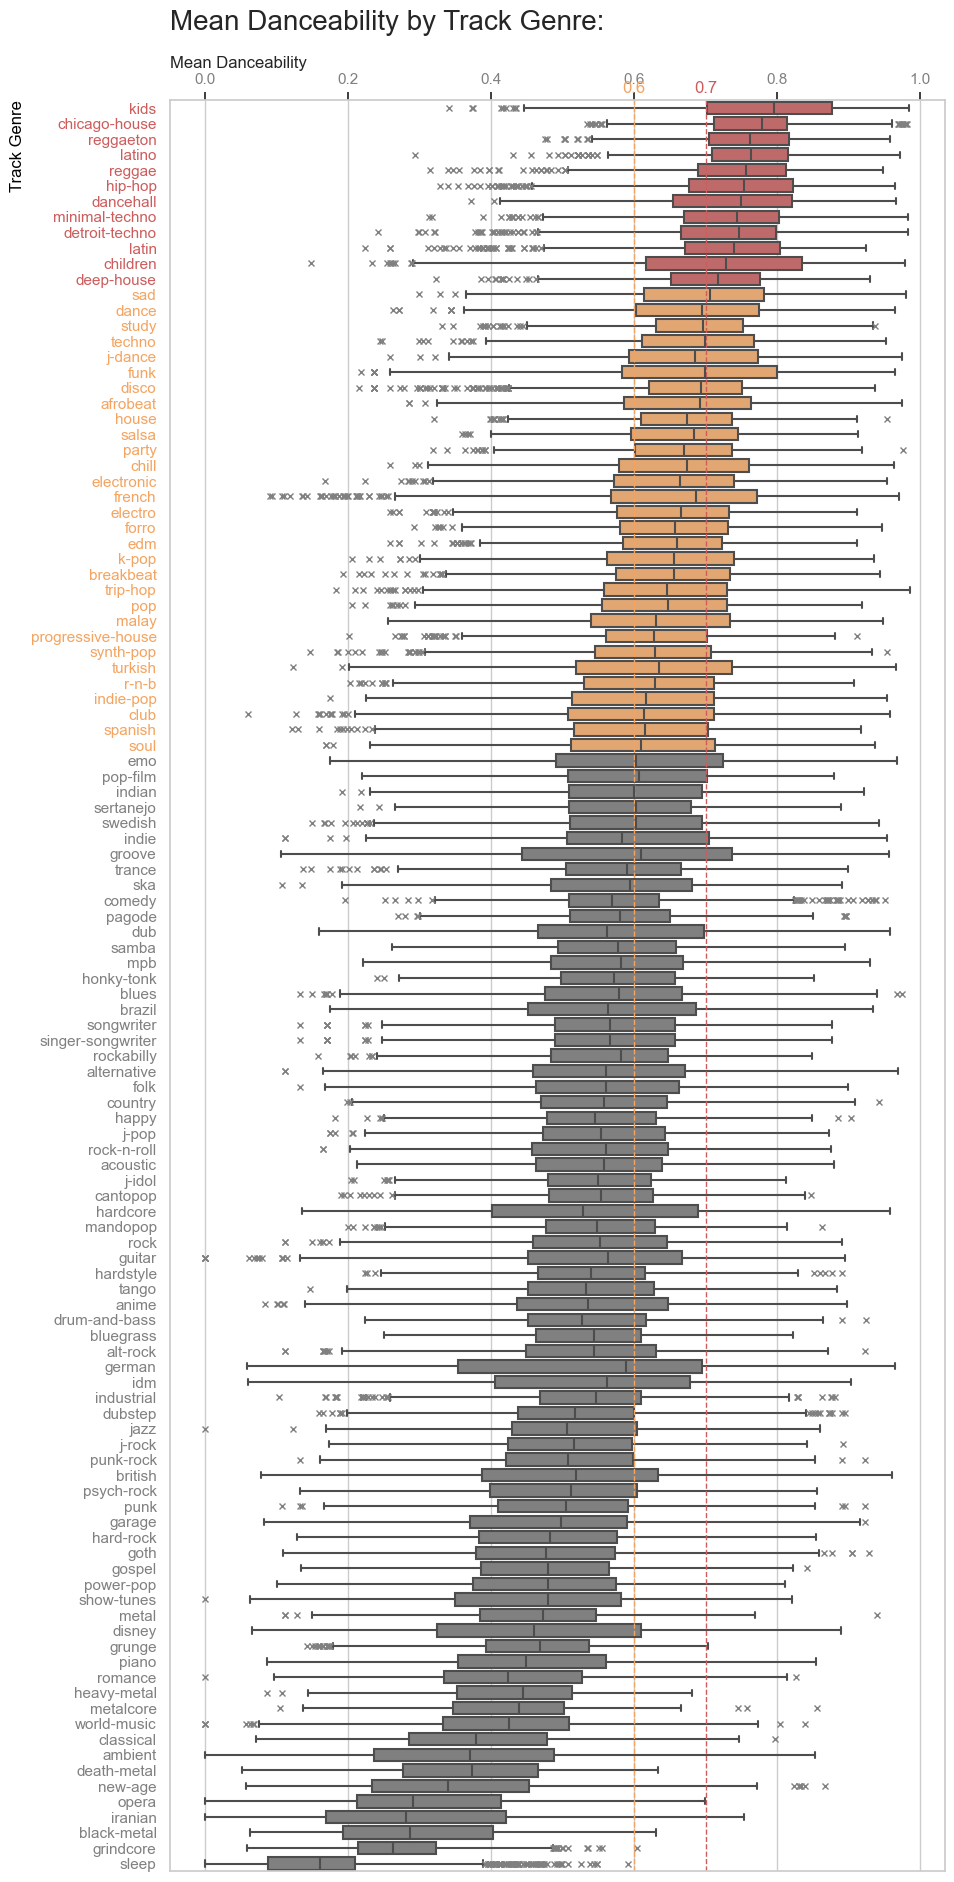

In [61]:
plt.figure(figsize=(10, 23))
sns.set(style="whitegrid")

mean_danceability = exploded_df.groupby('track_genre')['danceability'].mean().reset_index()
mean_danceability = mean_danceability.sort_values(by='danceability', ascending=False)

custom_palette = ['indianred' if mean >= 0.7 else 'gray' if mean < 0.6 else 'sandybrown' for mean in mean_danceability['danceability']]
outlier_props = {'markerfacecolor': 'gray', 'markeredgecolor': 'gray', 'markersize': 5, 'marker': 'x'}
sns.boxplot(x='danceability', y='track_genre', data=exploded_df, order=mean_danceability['track_genre'], palette=custom_palette, flierprops=outlier_props)

ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

for label in ax.get_xticklabels():
    label.set_color('gray')

plt.xlabel('Mean Danceability', loc='left')
plt.ylabel('Track Genre', loc='top', color='black')

for i, label in enumerate(ax.get_yticklabels()):
    label.set_color(custom_palette[i])

plt.title('Mean Danceability by Track Genre:', fontsize=20, loc='left', y=1.035)
plt.legend().remove()
ax.set_ylim(len(mean_danceability) - 0.5, -0.5)
plt.axvline(x=0.7, color='indianred', linestyle='--', linewidth=1)
plt.text(0.7, -1, '0.7', color='indianred', fontsize=12, ha='center')
plt.axvline(x=0.6, color='sandybrown', linestyle='--', linewidth=1)
plt.text(0.6, -1, '0.6', color='sandybrown', fontsize=12, ha='center')

plt.show()


### Observations:
- In the box plot version, we can discern an intriguing pattern: genres with a mean danceability score exceeding 0.6 consistently feature atleast one song with a danceability score of 0.9 or higher.
- Notably, genres such as German, British, and Disney exhibit the widest box plots. This width may indicate that these genres frequently overlap or blend with other genres, implying that they are less distinct or standalone in nature compared to other genres.
- The top genres tend to have more outliers on the left side of the box plot, while the bottom genres tend to have all their outliers on the right side of the plot.

## 3.4 Genre Co-occurence

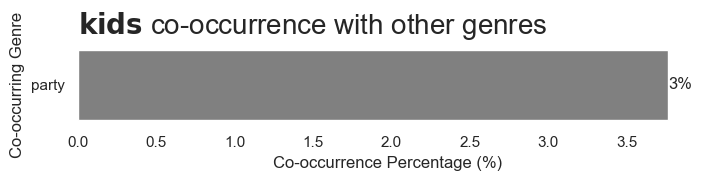

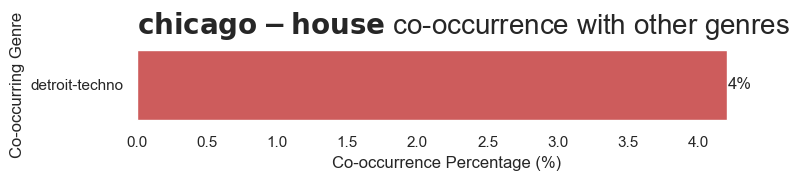

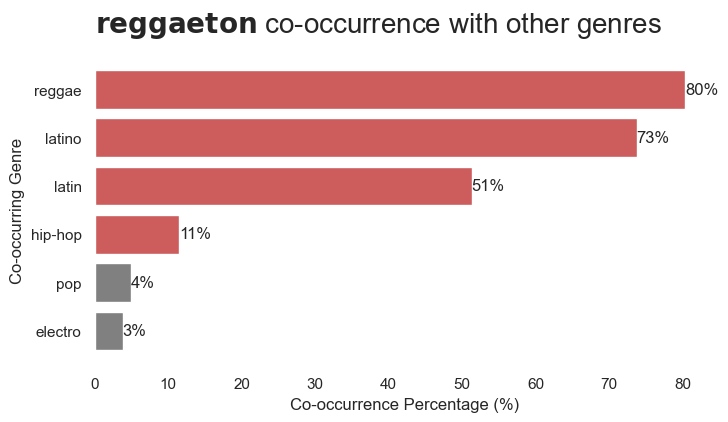

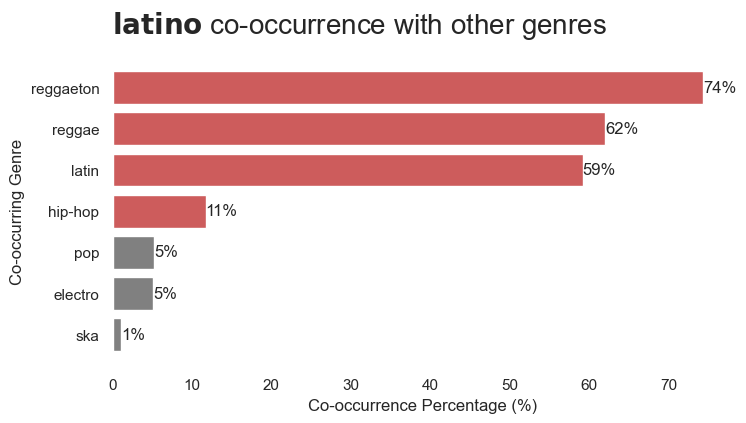

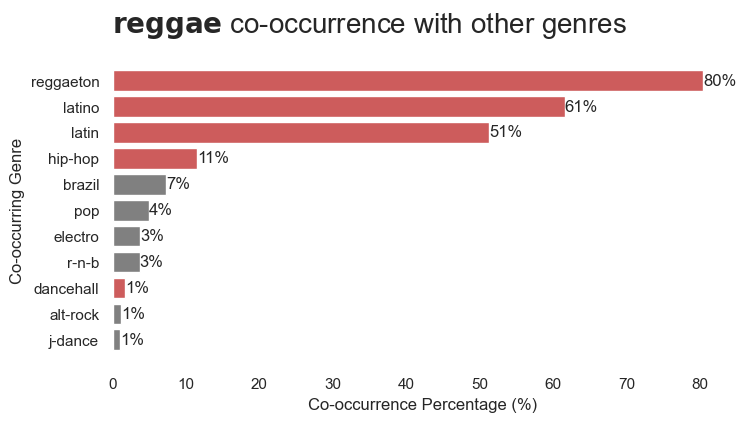

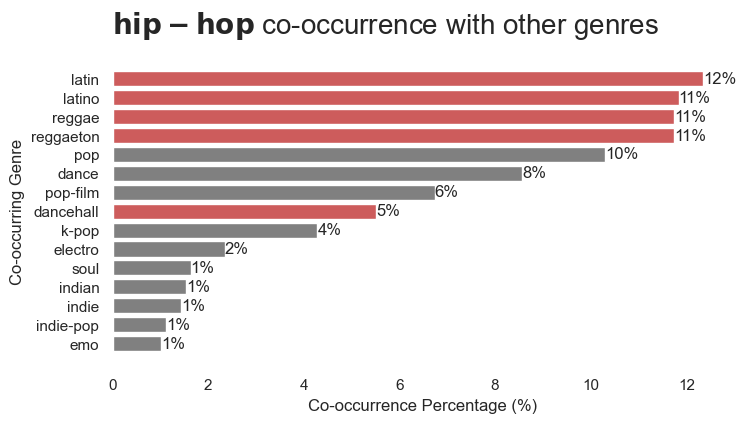

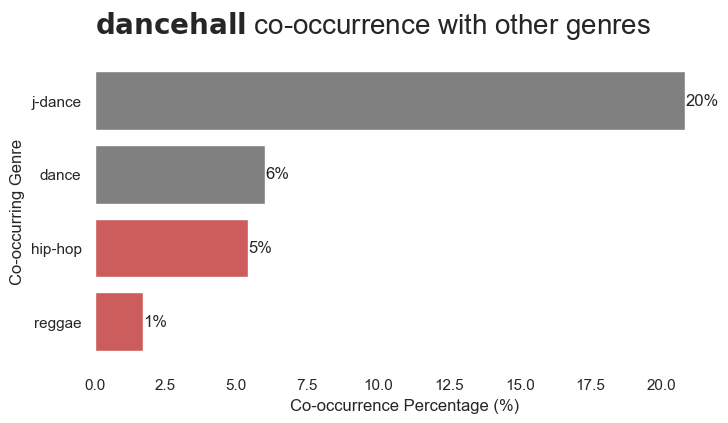

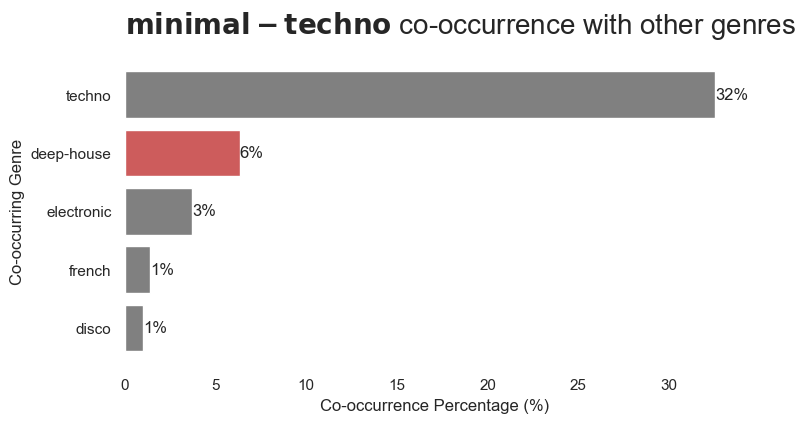

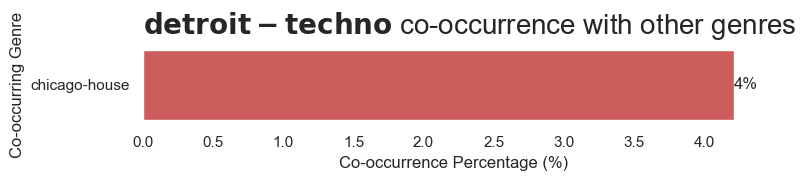

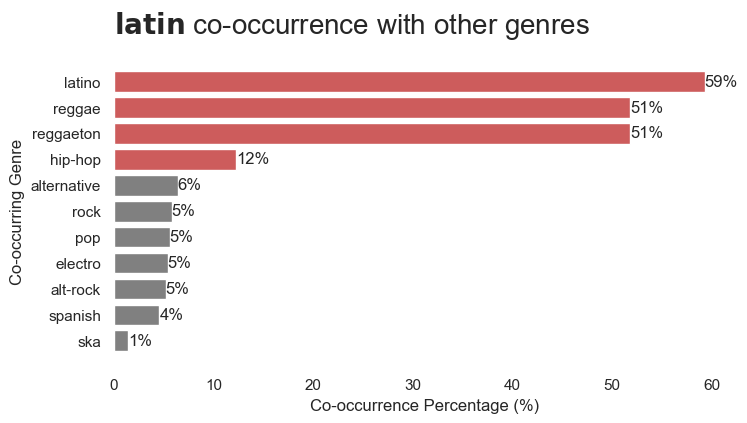

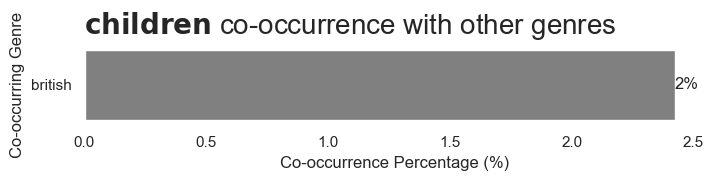

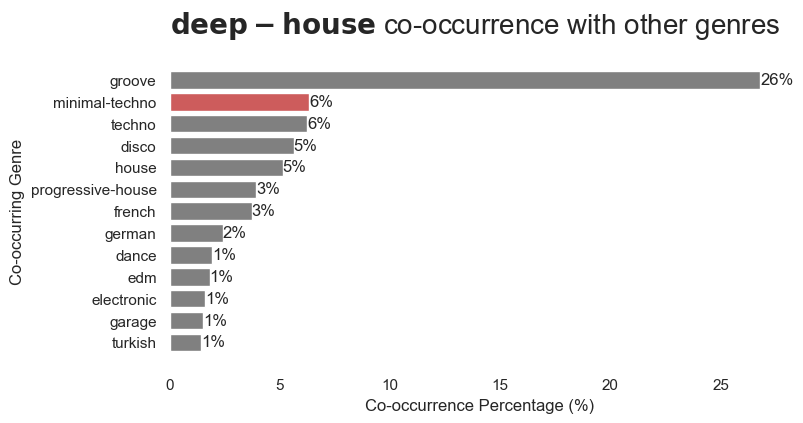

In [62]:
def genre_cooccurrence(genres_list, genre, top_list):
    filtered_list = [sublist for sublist in genres_list if genre in sublist]
    total_tracks = len(filtered_list)
    word_list = list(chain.from_iterable(filtered_list))
    filtered_word_list = list(filter(lambda word: word != genre, word_list))
    word_counts = Counter(filtered_word_list)
    word_count_list = [{'Genre': word, 'Cooccurrence_Percentage': (count / total_tracks) * 100} for word, count in                                                                                                                  word_counts.items()]
    df = pd.DataFrame(word_count_list)
    df = df[df['Cooccurrence_Percentage'] >= 1]

    if df.empty:
        print("No data points with cooccurrence percentage greater than or equal to 1% found.")
        return

    sorted_df = df.sort_values('Cooccurrence_Percentage', ascending=False)

    if len(sorted_df) == 1:
        fig, ax = plt.subplots(figsize=(8, 1))
    else:
        fig, ax = plt.subplots(figsize=(8, 4))

    colors = ['indianred' if genre in top_list else 'gray' for genre in sorted_df['Genre']]
    bars = ax.barh(sorted_df['Genre'], sorted_df['Cooccurrence_Percentage'], color=colors)
    ax.set_xlabel('Co-occurrence Percentage (%)')
    ax.set_ylabel('Co-occurring Genre')
    ax.set_title('{} co-occurrence with other genres'.format(r'$\mathbf{' + genre + '}$'), loc='left', fontsize=20, y=1.05)
    ax.invert_yaxis()

    for spine in ax.spines.values():
        spine.set_visible(False)

    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height() / 2, f'{int(width)}%', ha='left', va='center')

    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)

    plt.show()

genres_list = imploded_df['track_genre'].str.split(',')
mean_danceability = exploded_df.groupby('track_genre')['danceability'].mean().reset_index().sort_values('danceability', ascending=False)
top_list = list(mean_danceability[mean_danceability['danceability'] > 0.7]['track_genre'])

for i in top_list:
    genre_cooccurrence(genres_list, i, top_list)

### Observations:
- Genres such as "kid" and "children" exhibit minimal co-occurrence with other genres, primarily existing in isolation. Consequently, these genres may not be suitable suggestions for the event, as they primarily target a younger audience.
- Notably, "reggaeton" displays a significant degree of co-occurrence with genres like "reggae," "latino," and "latin." Given this strong association, it is essential to recognize that these genres share common elements and may not be distinct enough to be considered separate suggestions for the event.
- Among the top genres, "chicago-house," "reggaeton," "hip-hop," "dancehall," "minimal-techno," "detroit-techno," and "deep-house" appear to be valid and stand-alone and suitable options for consideration when planning music for a company party.

## 3.5 Correlation Heatmap

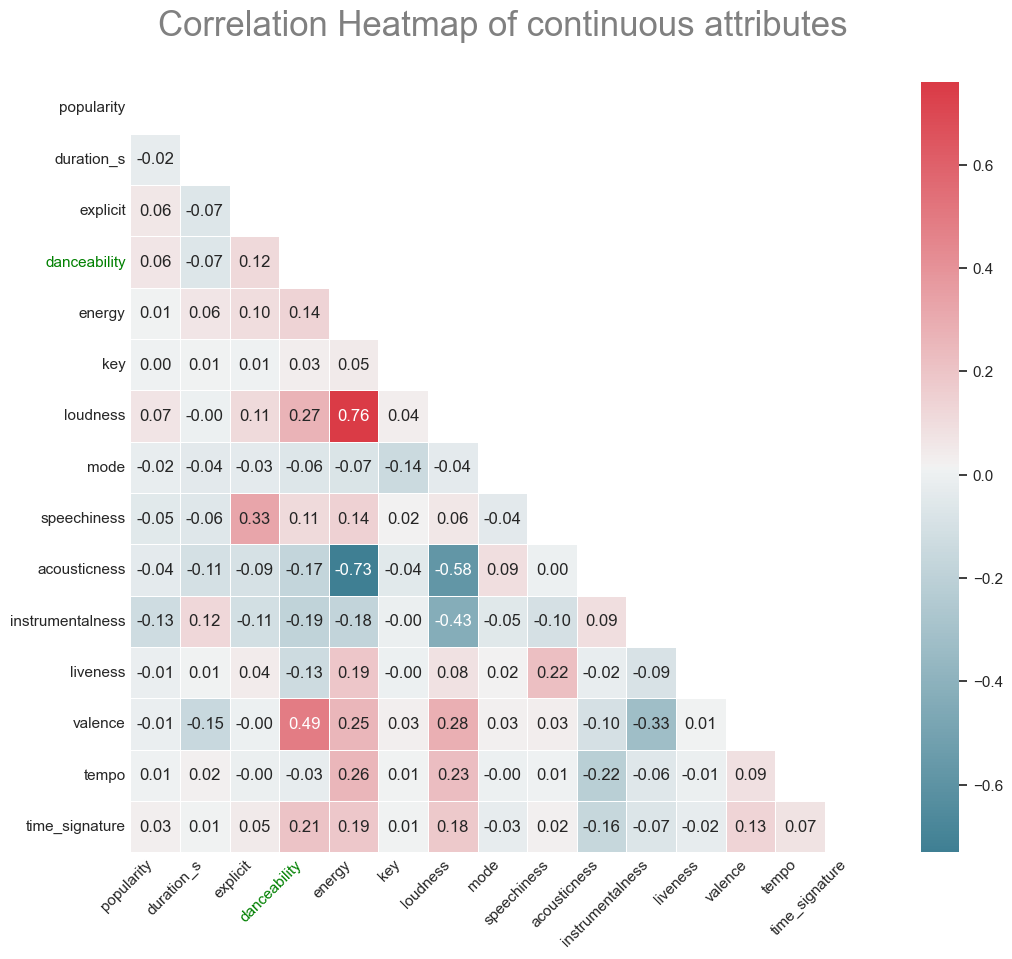

In [63]:
columns_to_include = ['popularity', 'duration_s', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

subset_df = imploded_df[columns_to_include]
corr_matrix = subset_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=colormap, mask=mask, linewidths=0.5, cbar=True)
plt.title('Correlation Heatmap of continuous attributes', fontsize=25, y=1.05, color='gray')
danceability_index = columns_to_include.index('danceability')
ax.get_xticklabels()[danceability_index].set_color('green')
ax.get_yticklabels()[danceability_index].set_color('green')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.xaxis.set_tick_params(length=0)
ax.yaxis.set_tick_params(length=0)

plt.show()

### Observations:
1. **Danceability and its Correlations**: Danceability doesn't exhibit strong correlations with most other features. It shows a moderate positive correlation with valence (0.49), suggesting that songs with a higher valence, which implies a happier mood, tend to be more danceable. Additionally, danceability has weaker positive correlations with loudness (0.27), energy (0.14), speechiness (0.14), and time signature (0.21). Conversely, it has weaker negative correlations with acousticness (-0.17), instrumentalness (-0.19), and liveness (-0.13).
2. **Tempo, Mode, and Key's Relationship with Danceability**: Danceability appears to be independent of tempo, mode, and key, as there is no notable correlation between these factors and danceability.
3. **Energy, Loudness, and Acousticness**: There exists a strong positive correlation (0.76) between energy and loudness, implying that energetic tracks tend to be louder. Conversely, energy has a substantial negative correlation with acousticness (-0.73), indicating that songs with higher acousticness scores are typically less energetic and may not be well-suited for danceability.
4. **Speechiness and Explicit Content**: Speechiness and the presence of explicit content exhibit a moderate positive correlation (0.33), suggesting that songs with more explicit language tend to have a slightly higher level of speechiness.

## 3.6 Scatter Plots

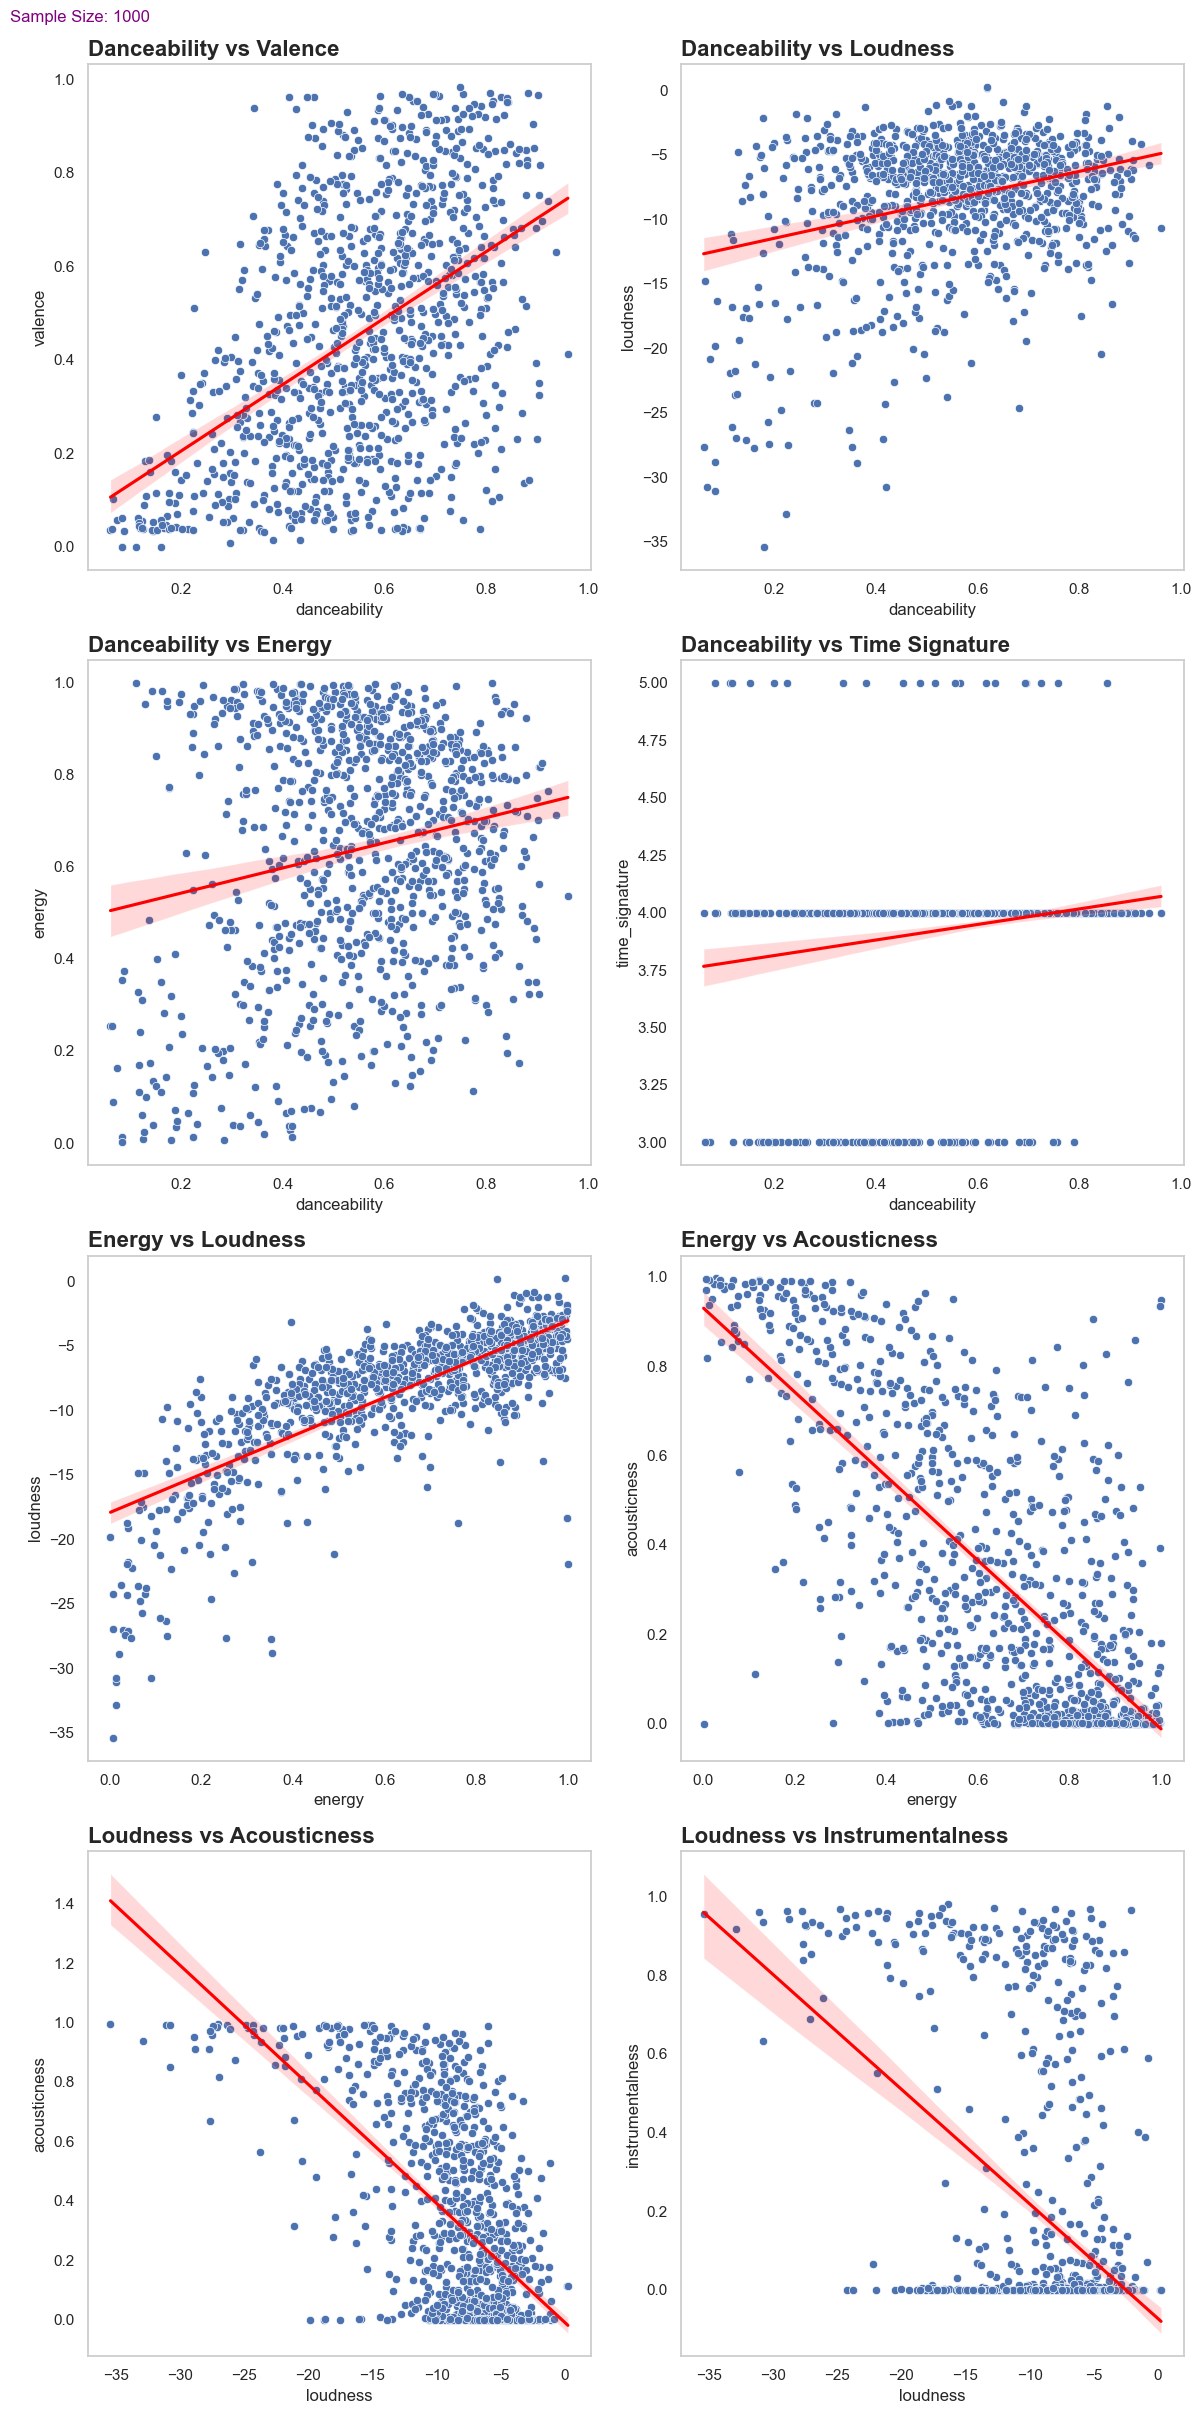

In [64]:
combinations = [
    ('danceability', 'valence', 'Danceability vs Valence'),
    ('danceability', 'loudness', 'Danceability vs Loudness'),
    ('danceability', 'energy', 'Danceability vs Energy'),
    ('danceability', 'time_signature', 'Danceability vs Time Signature'),
    ('energy', 'loudness', 'Energy vs Loudness'),
    ('energy', 'acousticness', 'Energy vs Acousticness'),
    ('loudness', 'acousticness', 'Loudness vs Acousticness'),
    ('loudness', 'instrumentalness', 'Loudness vs Instrumentalness')
]

sample_size = 1000
random.seed(42)
sampled_df = imploded_df.sample(n=sample_size)

num_rows = len(combinations) // 2 + len(combinations) % 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
fig.subplots_adjust(hspace=0.5)

for idx, (x_var, y_var, title) in enumerate(combinations):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    sns.scatterplot(x=x_var, y=y_var, data=sampled_df, ax=ax)
    sns.regplot(x=x_var, y=y_var, data=sampled_df, ax=ax, scatter=False, color='red')
    ax.set_title(title, fontsize=16, fontweight='bold', loc='left')
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.grid(False)

if len(combinations) % 2 == 1:
    fig.delaxes(axes[-1, -1])

plt.figtext(0, 1, f'Sample Size: {sample_size}', fontsize=12, ha='left', color='purple')
plt.tight_layout()
plt.show()

## 4.1 One-Hot Encoding

In [65]:
# one hot encoding
unique_genres = set()
for genres in imploded_df['track_genre'].str.split(','):
    unique_genres.update(genres)

for genre in unique_genres:
    encoded_genre = genre.replace(' ', '_')
    encoded_genre = ''.join(e for e in encoded_genre if e.isalnum() or e == '_')
    imploded_df[encoded_genre] = imploded_df['track_genre'].str.contains(genre).astype(int)

imploded_df.drop(columns=['track_genre'], inplace=True)

imploded_df.shape

(88895, 130)

We have about 130 columns in our dataset after applying one-hot encoding. Our next step is to implement Principal Component Analysis (PCA) on the one-hot encoded variables to assess whether a reduced number of principal components can effectively capture a significant portion of the dataset's variability.

## 4.2 Principal Component Analysis

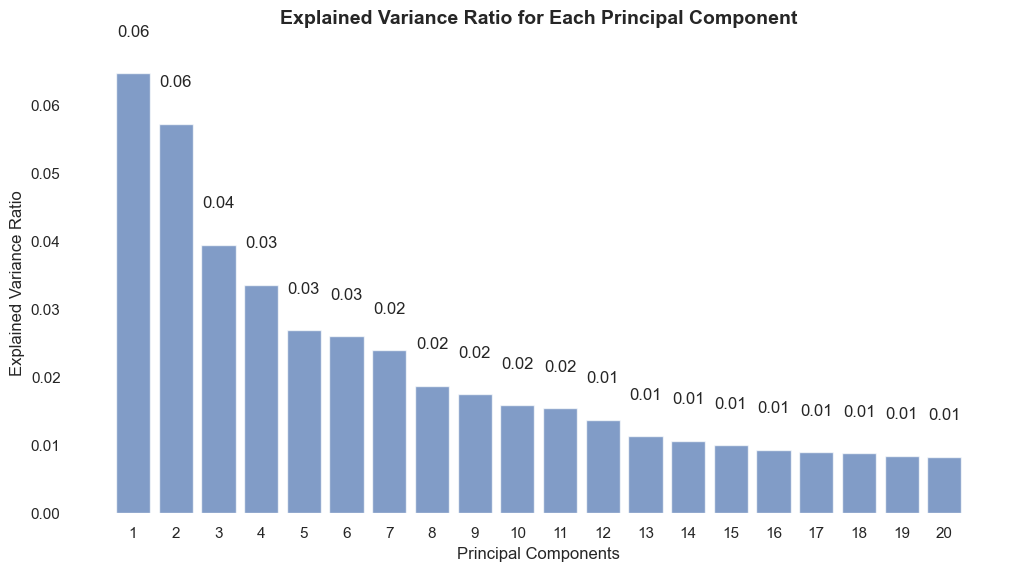

In [66]:
# split train and test
X = imploded_df.drop(columns=['danceability'])
y = imploded_df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_ids = X_train['track_id'].values
test_ids = X_test['track_id'].values

X_train = X_train.drop(columns=['track_id'])
X_test = X_test.drop(columns=['track_id'])

# PCA
X_train_unchanged = X_train.iloc[:,0:14]
X_test_unchanged = X_test.iloc[:,0:14]
X_train_selected = X_train.iloc[:,14:]
X_test_selected = X_test.iloc[:,14:]

pca = PCA(n_components=20)
X_train_selected_pca = pca.fit_transform(X_train_selected)
X_test_selected_pca = pca.transform(X_test_selected)

X_train_combined = np.concatenate((X_train_selected_pca, X_train_unchanged), axis=1)
X_test_combined = np.concatenate((X_test_selected_pca, X_test_unchanged), axis=1)

explained_variance_ratio = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center')

for bar, ratio in zip(bars, explained_variance_ratio):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f'{ratio:.2f}',
        ha='center',
        va='bottom',
        fontsize=12
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)
ax.grid(False)
ax.set_xticks(range(1, len(explained_variance_ratio) + 1))
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component', fontsize=14, fontweight='bold', pad=20)
plt.show()

**Observation:**
From the above graph, it appears that all the principal components contribute to explaining the variance in the data. Therefore, I have decided not to proceed with PCA and will retain all the original one-hot encoded variables for model building.

## Train-Test Split

In [67]:
X = imploded_df.drop(columns=['danceability'])
y = imploded_df['danceability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_ids = X_train['track_id'].values
test_ids = X_test['track_id'].values

X_train = X_train.drop(columns=['track_id'])
X_test = X_test.drop(columns=['track_id'])

## Model Building (models considered)
1. Random Forest Regression
2. Gradient Boosting Regression
3. AdaBoost Regression
4. Multiple Linear Regression
5. Lasso Regression
6. Ridge Regression

In [68]:
# model building, prediction and accuracy scores
models = [RandomForestRegressor(n_jobs=-1),
          GradientBoostingRegressor(),
          AdaBoostRegressor(),
          LinearRegression(),
          Lasso(),
          Ridge()]

trained_models = {}
for model in models:
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model_name = model.__class__.__name__
    print(f"{model_name} Mean Squared Error: {mse:.3f}")
    print(f"{model_name} R-squared: {r2:.3f}")
    print(f"{model_name} Cross Validation Scores: {', '.join([f'{score:.3f}' for score in cv_scores])}\n")
    
    trained_models[model_name] = model

RandomForestRegressor Mean Squared Error: 0.009
RandomForestRegressor R-squared: 0.694
RandomForestRegressor Cross Validation Scores: 0.693, 0.695, 0.698, 0.685, 0.688

GradientBoostingRegressor Mean Squared Error: 0.012
GradientBoostingRegressor R-squared: 0.611
GradientBoostingRegressor Cross Validation Scores: 0.619, 0.621, 0.631, 0.614, 0.616

AdaBoostRegressor Mean Squared Error: 0.017
AdaBoostRegressor R-squared: 0.440
AdaBoostRegressor Cross Validation Scores: 0.456, 0.452, 0.458, 0.461, 0.455

LinearRegression Mean Squared Error: 0.014
LinearRegression R-squared: 0.556
LinearRegression Cross Validation Scores: 0.556, 0.571, 0.570, 0.555, 0.553

Lasso Mean Squared Error: 0.031
Lasso R-squared: 0.002
Lasso Cross Validation Scores: 0.002, 0.002, 0.002, 0.002, 0.002

Ridge Mean Squared Error: 0.014
Ridge R-squared: 0.556
Ridge Cross Validation Scores: 0.556, 0.571, 0.569, 0.555, 0.553



**Observation:** From the above scores, it is observed that random forest regressor performs the best among other regression algorithms. So, proceeding with random forest regressor further for model interpretation.

## Random Forest Regression

Ridge Mean Squared Error: 0.009
Ridge R-squared: 0.694


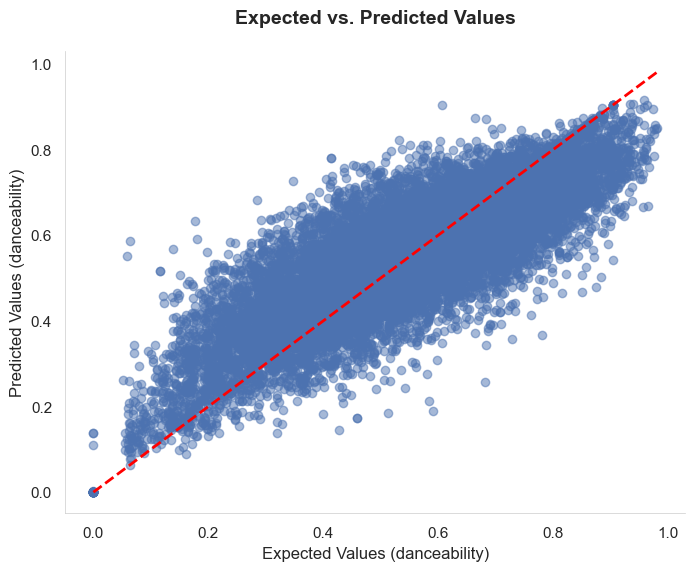

In [69]:
rf_model = trained_models["RandomForestRegressor"]
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"{model_name} Mean Squared Error: {mse:.3f}")
print(f"{model_name} R-squared: {r2:.3f}")

# visualizing predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title("Expected vs. Predicted Values", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Expected Values (danceability)")
plt.ylabel("Predicted Values (danceability)")
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()

**Observation:** The above scatter plot comparing the expected and predicted danceability values with an R-squared of 0.69 indicates a reasonably good fit between the model's predictions and the actual data. Our model accounts for approximately 69% of the variance in the data, suggesting a moderate level of predictive accuracy.

## Feature Importance

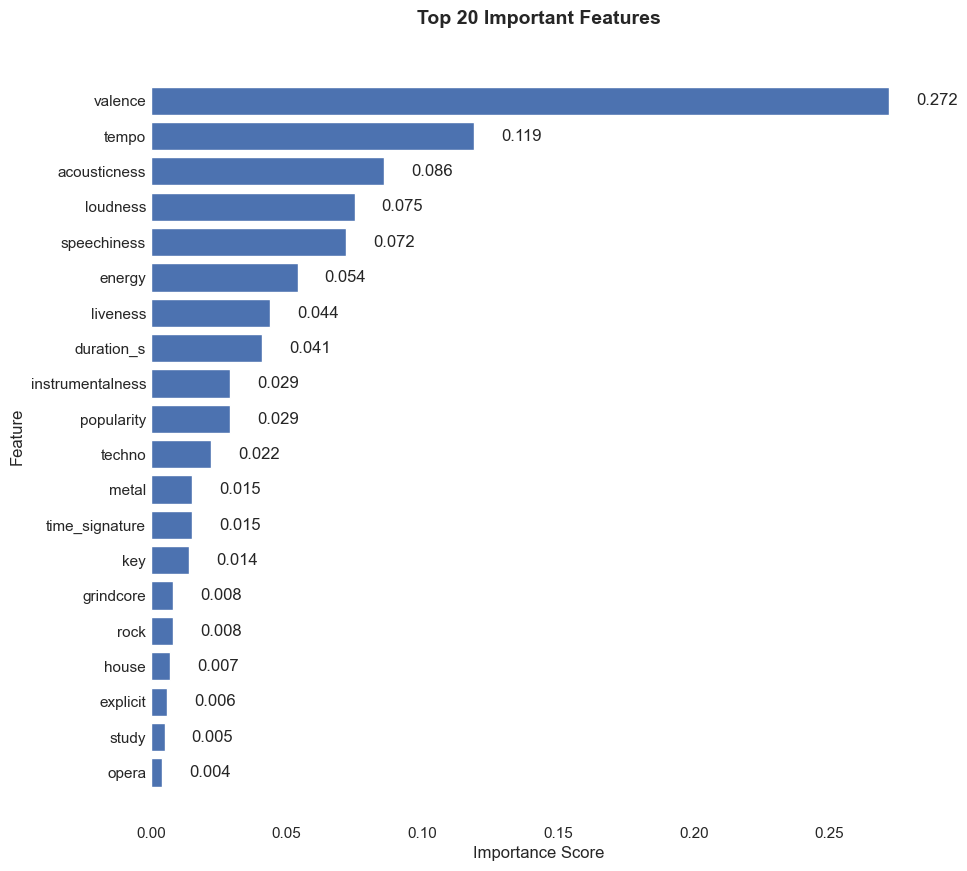

In [70]:
importances = rf_model.feature_importances_

top_n = 20
indices = importances.argsort()[::-1][:top_n]
top_importances = importances[indices]
top_feature_names = X_train.columns[indices]

rounded_importances = [round(importance, 3) for importance in top_importances]

plt.figure(figsize=(10, 10))
bars = plt.barh(range(top_n), rounded_importances, tick_label=top_feature_names)

for bar, importance in zip(bars, rounded_importances):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'{importance}', ha='left', va='center')

plt.title('Top 20 Important Features', fontsize=14, fontweight='bold', pad=20)

plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.grid(False)
plt.tick_params(axis='both', which='both', length=0)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### Observations:
- Among the features considered, **Valence** stands out as the most influential factor when predicting danceability
- While our correlation heatmap did not reveal a linear relationship between **Tempo** and danceability, it's noteworthy that the Random Forest Regressor appears to have captured a non-linear association between 'Tempo' and the dependent variable.
- It's interesting to note that **Acousticness** has a higher importance score than **Loudness**, which seems counterintuitive based on both our initial expectations and the correlations observed in our heatmap.
- Despite the high proportion of zeros in the one-hot encoded variables like **techno**, **metal**, **grindcore**, **rock**, **study**, **opera**, there might be instances where they have a value of 1 that strongly correlates with the target variable. In these instances, the presence of a particular genre like "techno," "metal," "grindcore," "rock", etc., could have a substantial impact on the model's predictions. The algorithm may have found that even though these features are sparse (mostly zeros), they contain valuable information when they are equal to 1. This information could've helped the model make better predictions, even if these values are rare. I believe techno, metal, grindcore and rock genres helped predict higher danceability score, where as study and opera helped the model in predicting lower danceability scores.

## Top 50 songs (as per model predictions on the test set)

In [71]:
top_50 = pd.DataFrame({'track_id': test_ids, 'danceability_predicted': y_pred})
top_50 = top_50.sort_values('danceability_predicted', ascending=False)
top_50 = top_50.head(50).reset_index(drop=True)

spotify_df = pd.read_csv('./data/spotify.csv')

def join_genres(genres):
    return ','.join(genres)
agg_dict = {'track_genre': join_genres,}
track_id_genre = spotify_df.groupby('track_id', as_index=False).agg(agg_dict)

spotify_df = spotify_df[['track_id', 'artists', 'album_name', 'track_name']].drop_duplicates()
top_50tracks = pd.merge(top_50, spotify_df, on='track_id', how='inner')
top_50tracks = pd.merge(top_50tracks, track_id_genre, on='track_id', how='inner')
top_50tracks

,track_id,danceability_predicted,artists,album_name,track_name,track_genre
0,12og6h0QdwBAvh7wG7m3H4,0.91704,Pj Panda,My Favorite Rapper Is a Panda,The Potty Song,kids
1,47bUyxG4UYJG2DKLdWrz2e,0.90705,CoComelon,Nursery Rhymes by CoComelon,This Is the Way,children
2,2oi26hzvmT9mbOGMBoEWtG,0.90623,CoComelon,Nursery Rhymes by CoComelon,Five Little Speckled Frogs,children
3,3XMZge3KZFAZmBCfNbUP19,0.90542,Cri-Cri,"Las 100 Clásicas de Cri Cri, Vol. 2",Orquesta De Animales,children
4,6q4IEBv1tWq3MHIBnCYYSS,0.90500,Jack Harlow,Hits Hits Hits,First Class,"hip-hop,k-pop"
5,1KfwlyvJQD1TA70RyC0Byd,0.90500,Jack Harlow,Hit After Hit,First Class,"hip-hop,k-pop"
6,6HIkxxaASDhaXdcMa2PFRB,0.90500,Jack Harlow,Am I Ready - Pop Night Out,First Class,"hip-hop,k-pop"
7,1jBIlZyCUOylXmEuLNvGCQ,0.90500,Jack Harlow,Totally Rap,First Class,"hip-hop,k-pop"
8,17TjJhR1wrGFW58aJnHpNC,0.90500,Jack Harlow,Your Perfect Soundtrack,First Class,"hip-hop,k-pop"
9,2GfARslWOjzRUtqCemkJmF,0.90500,Jack Harlow,Upbeat 20's,First Class,"hip-hop,k-pop"


- Oh dang, it seems that some kids' songs have made it into the top 50. I should have filtered out genres related to children's music before building the model.
- Can you believe it? There's this artist named Jack Harlow who apparently released the same track under different track IDs 🤦🏼‍♂️.
- and why are there same tracks in multiple albums?! ugh! I thought I handled dependencies among observations.
- thanks to this dataset, my top 50 songs list only contains 33 unique tracks. Well, it's not a big deal, I'll just make my colleagues groove to some songs on repeat, or they can head home.
- I notice that some songs in the dataset have the word 'dance' in their genre. Why bother with machine learning and all that when we can simply pick songs with 'dance' in their genre? It's frustrating. Of course, it's 2023, and there's an expectation to apply machine learning everywhere.
- I'd be confident in wagering that if I were to request 50 songs from a DJ, no machine learning model could surpass that DJ's recommendations. After all, the DJ might have unknowingly captured certain unique features that no machine learning model could even detect.
- I'll refrain from going off-topic now. By the way, thanks for taking the time to read!